In [1]:
#!pip install girth
from collections import defaultdict
from girth import twopl_jml, ability_mle, ability_map
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed
from uuid import  uuid4
from tqdm import tqdm
import sys
#import pickle
from pathlib import Path
sys.path.append("..")
from dirt import irf
RANDOM_STATE =1
seed(RANDOM_STATE)

In [2]:
def fit_model(dataset: pd.DataFrame,transpose=True):
    """Fit a two-parameter logistic model using the girth library
    
    Args: 
        dataset: an array of responses in the form of items x subjects
        transpose: transpose an array in the form of subject x items into one of items x subjects
        """
    if transpose:
        dataset = dataset.transpose()
    item_params = twopl_jml(dataset)
    abilities = ability_map(dataset=dataset.to_numpy(), difficulty = item_params["Difficulty"], discrimination=item_params["Discrimination"])
    return item_params, abilities

In [3]:
# def bit_flip(a,p=0.5):
#     flip = np.random.binomial(n=1,p=p)
#     return int(not (a == flip))

we want to show that as discrimination increases, the SEm decreases.

At the same time, we might as well show that classificaition accuracy increases

What we will do:
- generate items with fixed difficulties. these will not change.
- generate sets of items with different discrims. 
- compute test accuracy
- compute sem
- plot the results


In [4]:
#Let's try simulated data
N_ITEMS = 2000
N_SUBJECTS = 10_000
abilities = np.random.normal(size=N_SUBJECTS,loc=0,scale=1.01)
difficulties =   np.random.normal(size=N_ITEMS,loc=0,scale=1.01)
subjects = pd.DataFrame({"id": [str(uuid4()) for i in range(N_SUBJECTS) ], "ability": abilities})


In [5]:
data_path = Path().resolve().joinpath("data")
if not data_path.exists():
    data_path.mkdir(parents=True)
    
# with open(data_path.joinpath("discriminations.pkl"), "wb") as f:
#     pickle.dump(data_by_disc, f)

In [6]:
#FIXME ensure difficulties are declared
results = defaultdict(list)
disc_shapes = np.arange(0,2,0.25)

for disc_shape in disc_shapes:
    results["disc_shape"].append(disc_shape)


    #generate synthetic item params
    discriminations = np.random.gamma(size=N_ITEMS, shape=disc_shape, scale=2)
    results["mean_disc"].append(np.mean(discriminations))
    items = pd.DataFrame({"id": [str(uuid4()) for i in range(N_ITEMS)], "difficulty": difficulties, "discrimination": discriminations })
    
    #generate synthetic subject responses
    resp = list()
    for subject_idx, (subject_id, ability) in tqdm(subjects.iterrows(), "subject"):
        subj_responses = np.random.binomial(n=1,p=irf(diff=items["difficulty"],disc=items["discrimination"],ability=ability))
        resp.append(pd.Series(subj_responses,index=items.id,name=subject_id))
        
    #fit model for synthetic data corresponding to one set of discriminations
    data = pd.concat(resp,axis=1).transpose()
    test_subjects = data[-1000:]
    train_subjects = data[:-1000]
    itm, abl = fit_model(train_subjects)
    item_params = pd.DataFrame(itm, index=data.columns).reset_index()

    """compute test acc"""

    #prepare data for prediction
    long = list()
    for r in resp:
        if r.name in test_subjects.index:
        #prepare data for prediction
            rs = pd.DataFrame({"correct":r})
            rs["subject_id"] = r.name
            long.append(rs)
    long =pd.concat(long)
 
    #long is a dataframe of item_id, subject_id, correct
    long = long.reset_index().rename(columns={"id":"item_id"})
    #merge the item params on item ids
    long = item_params.merge(long,left_on="id",right_on="item_id").drop(columns="id")
    #merge the subject abilities on subject id
    long = long.merge(subjects.rename(columns={"id":"subject_id", "ability":"true_ability"}))

    """predict"""
    #note that because we are using true ability to make the prediction, the test accuracy is a measure of
    #how well we fit the item parameters, not the subject parameters

    long["y_pred"] =irf(ability=long["true_ability"], disc=long["Discrimination"], diff=long["Difficulty"])
    acc = (long["y_pred"].round().astype(int) ==long["correct"]).sum()/len(long)
    results["acc"].append(acc)

    """compute sem"""
    long["variance"] = long["y_pred"]*(1-long["y_pred"])
    overall_sem = long.groupby("true_ability").sum("variance")["variance"].map(np.sqrt).mean()
    results["sem"].append(overall_sem)


subject: 10000it [00:07, 1295.57it/s]
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
subject: 10000it [00:08, 1152.93it/s]
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
subject: 10000it [00:07, 1315.57it/s]
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
subject: 10000it [00:08, 1162.94it/s]
/home/daavid/PycharmProjects/IRT/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353:

In [7]:
results_df = pd.DataFrame(results)

In [9]:
results_df.to_csv(data_path.joinpath("disc_acc_sem.csv"))

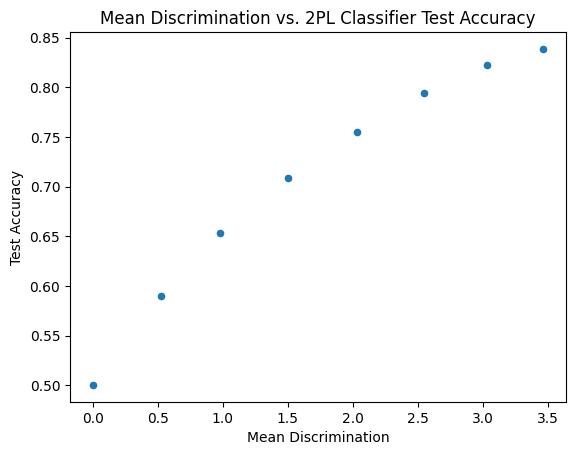

In [10]:
results_df.plot.scatter(x="mean_disc",y="acc")
plt.title("Mean Discrimination vs. 2PL Classifier Test Accuracy")
plt.xlabel("Mean Discrimination")
plt.ylabel("Test Accuracy")
plt.savefig("mean_disc_acc.png")

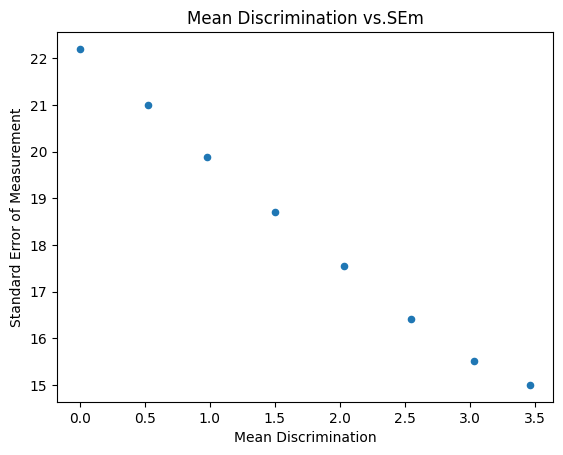

In [11]:
results_df.plot.scatter(x="mean_disc",y="sem")
plt.title("Mean Discrimination vs.SEm")
plt.xlabel("Mean Discrimination")
plt.ylabel("Standard Error of Measurement")
plt.savefig("mean_disc_sem.png")